### Day1の取り組み
#### 課題の決定
* 住宅販売価格予想
#### データの中身の理解
* カラムの意味のまとめ
* CSVファイルの中身の確認
#### 目的変数、説明変数の決定
* 相関行列の作成
* 散布図の作成
#### データ前処理
* 欠損値の確認
* 地下室の有無、改築の有無等、one-hot vector化
#### データ分析
* 手法：重回帰分析
* 相関係数の高い変数を説明変数に採用
* 最終的には 0.671 の精度を達成

### Day2の取り組み
#### データ前処理
* 説明変数の追加(郵便番号、購入月を one-hot vector化)
#### データ分析
* 手法：ランダムフォレスト + 交差検証法
* 最終的には 0.803 の精度を達成

### Day3の取り組み
#### データ分析
* SVM
* ニューラルネットワーク

# Day1

### 取り組み課題：住宅販売価格予想
### Kaggle から kc_house_data.csv を取得
### カラムの意味/タイプ
| 変数名 | 意味 | 変数タイプ | 備考 |  
|:------:|:----:|:----------:|:----:|  
|id|データID|Number|データ数は21613|
|date|売却された日付|文字列||
|price|住宅販売価格|Number||
|bedrooms|1戸当たりのベッドルーム数|Number|値範囲:0-33|
|bathrooms|ベッドルーム当たりの風呂数|Number|値範囲:0-8|
|sqft_living|延床面積|Number||
|sqft_lot|土地面積|Number||
|floors|階数|Number|値範囲:1-3.5|
|waterfront|水際かどうか|文字列|値範囲:0-1|
|view|眺めが良いかどうか|文字列(0-4)|値範囲:0-4|
|condition|家の状態|文字列(1-5)|値範囲:1-5|
|grade|グレード|文字列(1-13)|値範囲:1-13|
|sqft_above|地下室を除いた延床面積|Number||
|sqft_basement|地下室の延床面積|Number||
|yr_built|建築年|Number||
|yr_renovated|改修年|Number||
|zipcode|郵便番号|Number||
|lat|緯度|Number||
|long|経度|Number||
|sqft_living15|2015年時点での延床面積|Number||
|sqft_lot15|2015年時点での土地面積|Number||

In [52]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.wrappers.scikit_learn import KerasRegressor

In [53]:
# Kaggle から取得した kc_house_data.csv を読み込む
input_file = "./kc_house_data.csv"
df_data = pd.read_csv(input_file)

In [54]:
# 読み込んだ CSV ファイルのカラムを確認
print(df_data.columns)

# データの中身を確認
display(df_data.head())
display(df_data.tail())

# 住宅価格を 10^6 で割っておく
df_data["price"] = df_data["price"] / 10**6

# 統計情報を確認
display(df_data.describe(include='all'))

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
21608,263000018,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,6600060120,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,1523300141,20140623T000000,402101.0,2,0.75,1020,1350,2.0,0,0,...,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,291310100,20150116T000000,400000.0,3,2.50,1600,2388,2.0,0,0,...,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287
21612,1523300157,20141015T000000,325000.0,2,0.75,1020,1076,2.0,0,0,...,7,1020,0,2008,0,98144,47.5941,-122.299,1020,1357


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,21613,21613.000000,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,...,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
unique,NaN,372,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,20140623T000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,4.580302e+09,NaN,0.540088,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,...,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,NaN,0.367127,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,...,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,NaN,0.075000,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,...,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,NaN,0.321950,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,...,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,NaN,0.450000,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,...,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,NaN,0.645000,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,...,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000


In [55]:
# 変数間の相関性をチェックする
# 相関行列の表示
df_data.corr().style.background_gradient().format('{:.2f}')

# price に対して、bathrooms/sqft_living/grade/sqft_above/sqft_living15 辺りが高い相関を示している

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.00,-0.02,0.00,0.01,-0.01,-0.13,0.02,-0.00,0.01,-0.02,0.01,-0.01,-0.01,0.02,-0.02,-0.01,-0.00,0.02,-0.00,-0.14
price,-0.02,1.00,0.31,0.53,0.70,0.09,0.26,0.27,0.40,0.04,0.67,0.61,0.32,0.05,0.13,-0.05,0.31,0.02,0.59,0.08
bedrooms,0.00,0.31,1.00,0.52,0.58,0.03,0.18,-0.01,0.08,0.03,0.36,0.48,0.30,0.15,0.02,-0.15,-0.01,0.13,0.39,0.03
bathrooms,0.01,0.53,0.52,1.00,0.75,0.09,0.50,0.06,0.19,-0.12,0.66,0.69,0.28,0.51,0.05,-0.20,0.02,0.22,0.57,0.09
sqft_living,-0.01,0.70,0.58,0.75,1.00,0.17,0.35,0.10,0.28,-0.06,0.76,0.88,0.44,0.32,0.06,-0.20,0.05,0.24,0.76,0.18
sqft_lot,-0.13,0.09,0.03,0.09,0.17,1.00,-0.01,0.02,0.07,-0.01,0.11,0.18,0.02,0.05,0.01,-0.13,-0.09,0.23,0.14,0.72
floors,0.02,0.26,0.18,0.50,0.35,-0.01,1.00,0.02,0.03,-0.26,0.46,0.52,-0.25,0.49,0.01,-0.06,0.05,0.13,0.28,-0.01
waterfront,-0.00,0.27,-0.01,0.06,0.10,0.02,0.02,1.00,0.40,0.02,0.08,0.07,0.08,-0.03,0.09,0.03,-0.01,-0.04,0.09,0.03
view,0.01,0.40,0.08,0.19,0.28,0.07,0.03,0.40,1.00,0.05,0.25,0.17,0.28,-0.05,0.10,0.08,0.01,-0.08,0.28,0.07
condition,-0.02,0.04,0.03,-0.12,-0.06,-0.01,-0.26,0.02,0.05,1.00,-0.14,-0.16,0.17,-0.36,-0.06,0.00,-0.01,-0.11,-0.09,-0.00


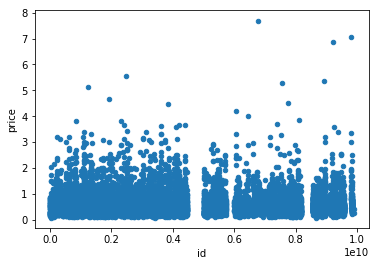

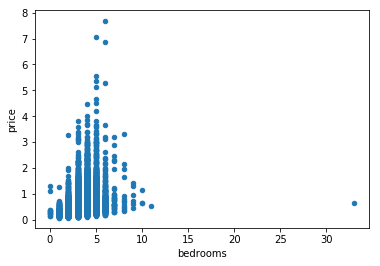

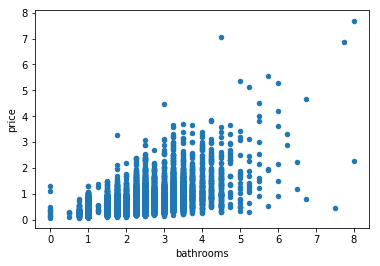

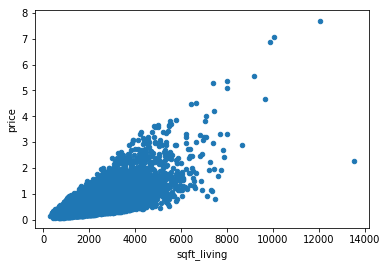

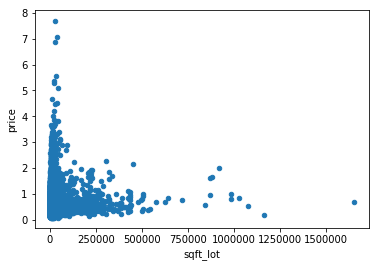

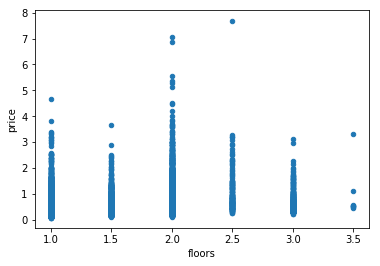

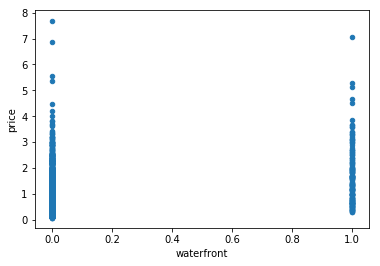

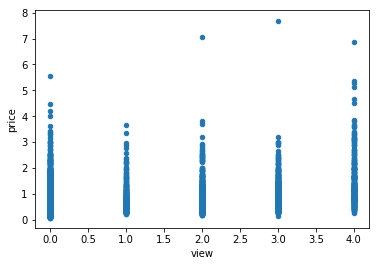

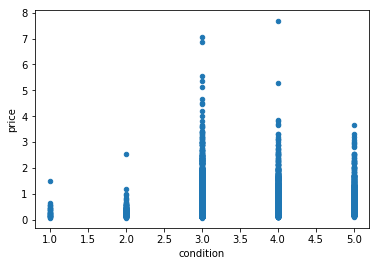

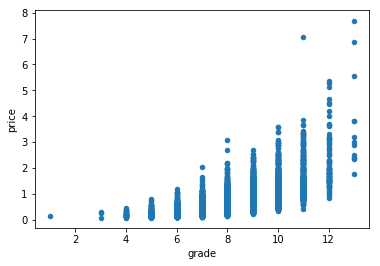

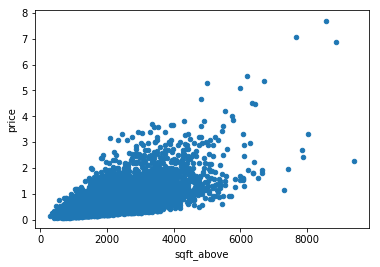

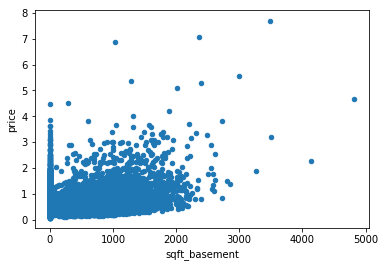

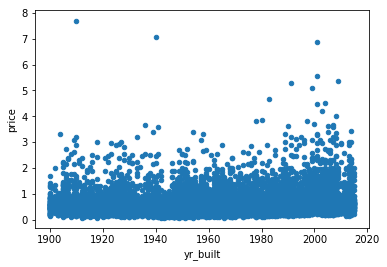

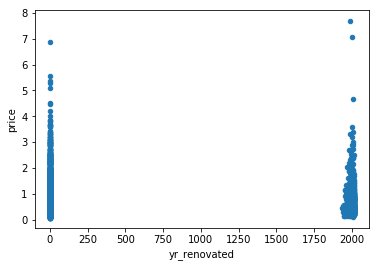

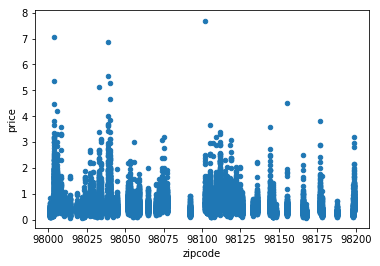

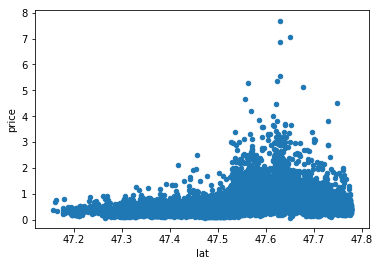

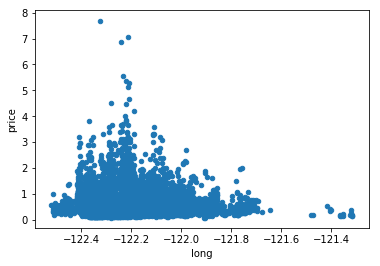

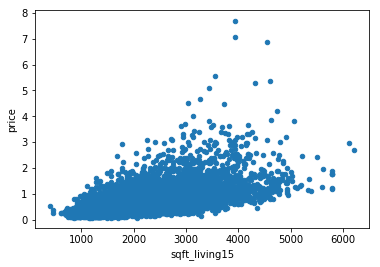

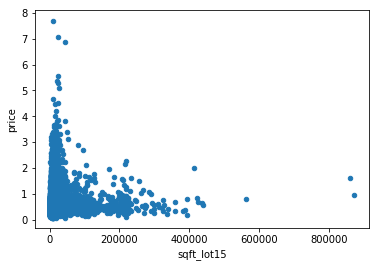

In [56]:
# さらに price に対する関係性を見るため、price x 他の変数の散布図を作成
for c in df_data.columns:
    if (c != 'price') & (c != 'date'):
        df_data[[c, 'price']].plot(kind='scatter', x=c, y='price')

### 目的変数を説明する説明変数を見つける  
先ずは、price と相関係数の高い順に考える
* 0.7 以上 -> sqft_living
* 0.6 以上 -> grade/sqft_above
* 0.5 以上 -> bathrooms/sqft_living15

ただし、sqft_above/sqft_living15 は sqft_living とほとんど同じ意味なので、これらの変数としては、sqrt_living を用いる。

In [57]:
# 欠損値を確認する
df_data.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [58]:
def get_estimation(regr, index, method, parameters, description, X_train, y_train, X_test, y_test):
    score_train = round(regr.score(X_train, y_train), 5)
    y_train_pred = regr.predict(X_train)
    mse_train = round(mean_squared_error(y_train, y_train_pred), 3)
    mae_train = round(mean_absolute_error(y_train, y_train_pred), 3)
    rmse_train = round(np.sqrt(mse_train), 3)
    
    print("訓練データに対する結果")
    print("決定係数=%s"%score_train)
    print("MSE=%s"%mse_train)
    print("RMSE=%s"%rmse_train)
    print("MAE=%s"%mae_train)

    score_test = round(regr.score(X_test, y_test), 5)
    y_pred = regr.predict(X_test)
    mse = round(mean_squared_error(y_test, y_pred), 3)
    mae = round(mean_absolute_error(y_test, y_pred), 3)
    rmse = round(np.sqrt(mse), 3)
    
    print("テストデータに対する結果")
    print("決定係数=%s"%score_test)
    print("MSE=%s"%mse)
    print("RMSE=%s"%rmse)
    print("MAE=%s"%mae)
    
    df_result = pd.DataFrame([[method,
                               str(score_test)+" / "+str(score_train), 
                               str(mse)+" / "+str(mse_train), 
                               str(rmse)+" / "+str(rmse_train), 
                               str(mae)+" / "+str(mae_train),
                               parameters,
                               description]],
                               columns=["Method", "Score(test/train)", "mse(test/train)", "rmse(test/train)", "mae(test/train)", "Parameters", "description"],
                               index=[index])
    
    return df_result    

In [59]:
def multi_reg(X, y, index, parameters, description):
    # テストデータと訓練データの生成
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

    regr = LinearRegression(fit_intercept=True)
    regr.fit(X_train, y_train)
    print("傾き=%s"%regr.coef_, "切片=%s"%regr.intercept_)

    method = "multiple_regression"
    df_result = get_estimation(regr, index, method, parameters, description, X_train, y_train, X_test, y_test)
    
    return df_result

In [60]:
# 結果を格納する DataFrame を用意
df_results = pd.DataFrame(columns=["Method", "Score(test/train)", "mse(test/train)", "rmse(test/train)", "mae(test/train)", "Parameters", "description"])

# 重回帰分析で説明することを試みる

y = df_data["price"].values
X = df_data[["sqft_living", "grade", "bathrooms"]].values
parameters = "sqft_living/grade/bathrooms"
index = "Try1"
description = ""

df_result = multi_reg(X, y, index, parameters, description)

df_results = df_results.append(df_result)

display(df_results)

傾き=[ 0.0002044   0.10337222 -0.037286  ] 切片=-0.596962845334241
訓練データに対する結果
決定係数=0.53701
MSE=0.063
RMSE=0.251
MAE=0.164
テストデータに対する結果
決定係数=0.53754
MSE=0.061
RMSE=0.247
MAE=0.164


,Method,Score(test/train),mse(test/train),rmse(test/train),mae(test/train),Parameters,description
Try1,multiple_regression,0.53754 / 0.53701,0.061 / 0.063,0.247 / 0.251,0.164 / 0.164,sqft_living/grade/bathrooms,


### 考察  
決定係数が 0.537 とあまり高くない結果が得られた。  
原因としては、以下が考えられる。
* price と他の変数の相関関係を見るときに、延床面積の影響が高すぎるため、相関関係が見えない、精度が上がらないのではないか。  
  -> price/sqft_living を定義しなおし、他の変数との相関関係を探る。  
* ある特定の地域の住宅価格が高いことはないか。  
  -> zipcode, lat, long の組み合わせを見てみる価値はあるかも。
* 地下室面積を変数とするのではなく、地下室があるかどうかを判断材料とするのはどうか。
* 改修年を変数とするのではなく、改修したかどうかを判断材料とするのはどうか。
* 建築年を変数とするのではなく、建築年でクラス分けして、変数とするのはどうか。  
  -> 1: 1900-1920, 2: 1920-1940, 3: 1940-1960 ...
* 外れ値の除去を試みた場合、全体の精度は上がるかどうか。

In [61]:
# 延床面積当たりを考える。
#df_data["price_per_sqft_living"] = df_data["price"] / df_data["sqft_living_norm"]
df_data["price_per_sqft_living"] = df_data["price"] / df_data["sqft_living"]
df_data["price_per_sqft_living"].describe()

# 変数間の相関性をチェックする
# 相関行列の表示
df_data.corr().style.background_gradient().format('{:.2f}')

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price_per_sqft_living
id,1.00,-0.02,0.00,0.01,-0.01,-0.13,0.02,-0.00,0.01,-0.02,0.01,-0.01,-0.01,0.02,-0.02,-0.01,-0.00,0.02,-0.00,-0.14,-0.01
price,-0.02,1.00,0.31,0.53,0.70,0.09,0.26,0.27,0.40,0.04,0.67,0.61,0.32,0.05,0.13,-0.05,0.31,0.02,0.59,0.08,0.55
bedrooms,0.00,0.31,1.00,0.52,0.58,0.03,0.18,-0.01,0.08,0.03,0.36,0.48,0.30,0.15,0.02,-0.15,-0.01,0.13,0.39,0.03,-0.21
bathrooms,0.01,0.53,0.52,1.00,0.75,0.09,0.50,0.06,0.19,-0.12,0.66,0.69,0.28,0.51,0.05,-0.20,0.02,0.22,0.57,0.09,-0.09
sqft_living,-0.01,0.70,0.58,0.75,1.00,0.17,0.35,0.10,0.28,-0.06,0.76,0.88,0.44,0.32,0.06,-0.20,0.05,0.24,0.76,0.18,-0.09
sqft_lot,-0.13,0.09,0.03,0.09,0.17,1.00,-0.01,0.02,0.07,-0.01,0.11,0.18,0.02,0.05,0.01,-0.13,-0.09,0.23,0.14,0.72,-0.03
floors,0.02,0.26,0.18,0.50,0.35,-0.01,1.00,0.02,0.03,-0.26,0.46,0.52,-0.25,0.49,0.01,-0.06,0.05,0.13,0.28,-0.01,0.00
waterfront,-0.00,0.27,-0.01,0.06,0.10,0.02,0.02,1.00,0.40,0.02,0.08,0.07,0.08,-0.03,0.09,0.03,-0.01,-0.04,0.09,0.03,0.19
view,0.01,0.40,0.08,0.19,0.28,0.07,0.03,0.40,1.00,0.05,0.25,0.17,0.28,-0.05,0.10,0.08,0.01,-0.08,0.28,0.07,0.22
condition,-0.02,0.04,0.03,-0.12,-0.06,-0.01,-0.26,0.02,0.05,1.00,-0.14,-0.16,0.17,-0.36,-0.06,0.00,-0.01,-0.11,-0.09,-0.00,0.10


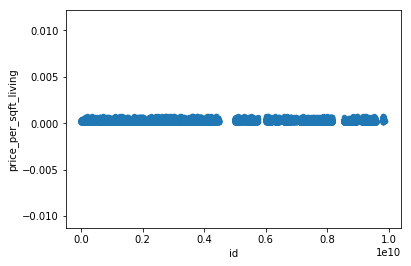

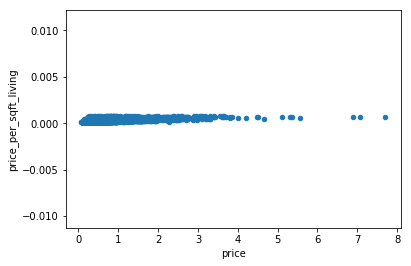

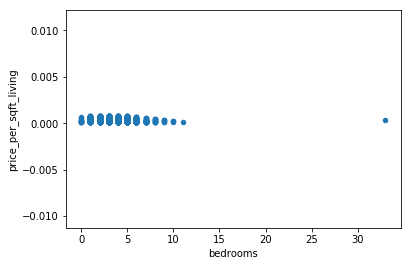

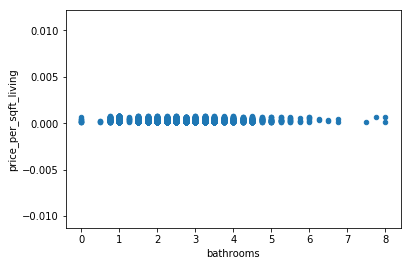

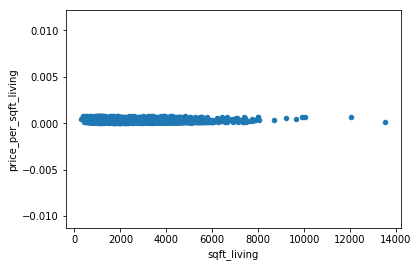

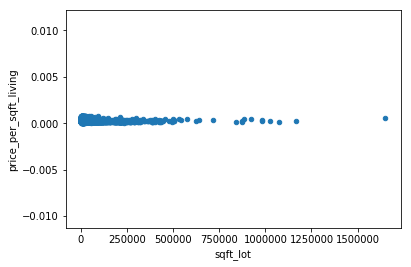

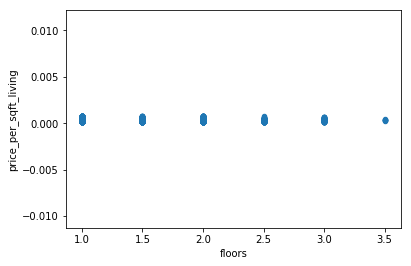

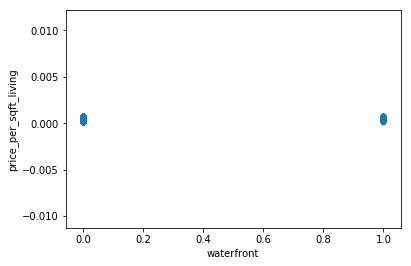

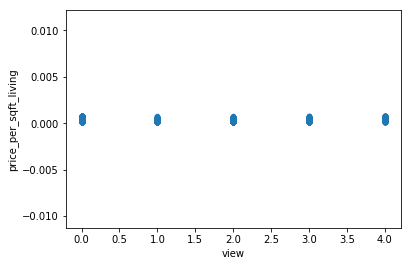

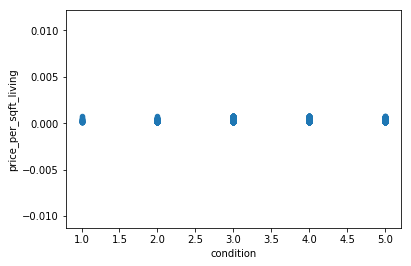

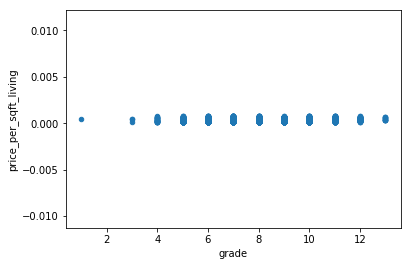

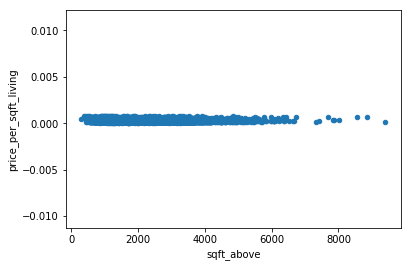

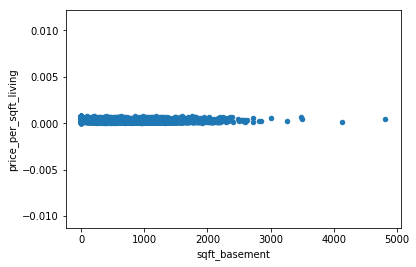

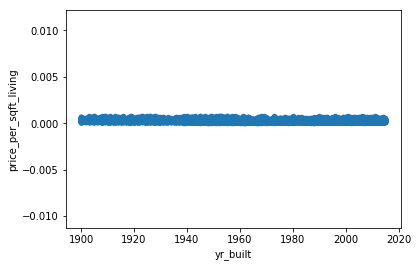

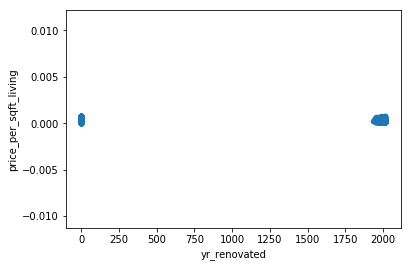

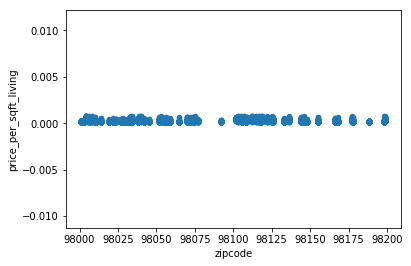

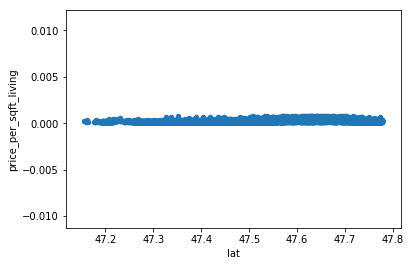

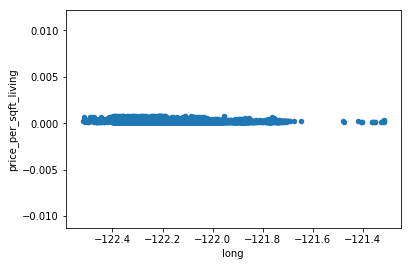

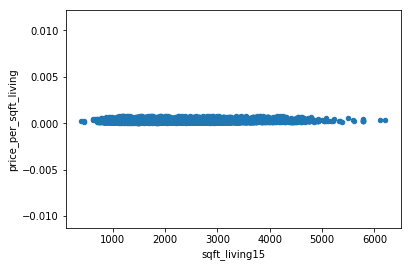

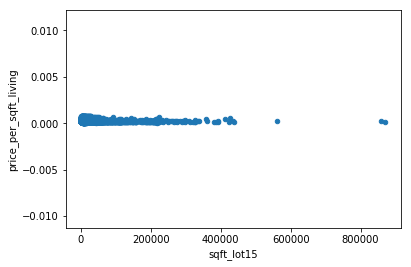

In [62]:
# さらに price に対する関係性を見るため、price x 他の変数の散布図を作成
for c in df_data.columns:
    if (c != 'price_per_sqft_living') & (c != 'date'):
        df_data[[c, 'price_per_sqft_living']].plot(kind='scatter', x=c, y='price_per_sqft_living')

### 考察2
延床面積当たりで見ても、あまり参考になる結果とはならなかった。。。  
→　表示範囲を変えたらどうなるか？
### 最初の状態から地下室の有無を加えてみる

In [63]:
# 地下室面積ではなく、地下室があるかどうかを判断材料とする。
# 0: 地下室がない 1: 地下室がある
df_data['basement'] = np.array(df_data['sqft_basement'] != 0)*1
df_data['basement'].value_counts().sort_index()

# 重回帰分析で説明することを試みる

y = df_data["price"].values
X = df_data[["sqft_living", "grade", "bathrooms", "basement"]].values
parameters = "Try1 + basement"
index = "Try2"
description = ""

df_result = multi_reg(X, y, index, parameters, description)

df_results = df_results.append(df_result)

display(df_results)

傾き=[ 0.00019439  0.109222   -0.03977256  0.05394086] 切片=-0.6369640687273703
訓練データに対する結果
決定係数=0.54177
MSE=0.062
RMSE=0.249
MAE=0.162
テストデータに対する結果
決定係数=0.54633
MSE=0.06
RMSE=0.245
MAE=0.161


,Method,Score(test/train),mse(test/train),rmse(test/train),mae(test/train),Parameters,description
Try1,multiple_regression,0.53754 / 0.53701,0.061 / 0.063,0.247 / 0.251,0.164 / 0.164,sqft_living/grade/bathrooms,
Try2,multiple_regression,0.54633 / 0.54177,0.06 / 0.062,0.245 / 0.249,0.161 / 0.162,Try1 + basement,


### 考察3
決定係数が 0.537 -> 0.542 になったものの、大して変化せず。。。
### 最初の状態から改修の有無を加える

In [64]:
# リノベーション年はリノベーションしたかどうかに変換する
df_data['renovate'] = np.array(df_data['yr_renovated'] != 0)*1
df_data['renovate'].value_counts().sort_index()

# 重回帰分析で説明することを試みる

y = df_data["price"].values
X = df_data[["sqft_living", "grade", "bathrooms", "renovate"]].values
parameters = "Try1 + renovate"
index = "Try3"
description = ""

df_result = multi_reg(X, y, index, parameters, description)

df_results = df_results.append(df_result)

display(df_results)

傾き=[ 0.0002012   0.1056746  -0.03899236  0.17831118] 切片=-0.6116795064877452
訓練データに対する結果
決定係数=0.54621
MSE=0.062
RMSE=0.249
MAE=0.162
テストデータに対する結果
決定係数=0.54849
MSE=0.059
RMSE=0.243
MAE=0.162


,Method,Score(test/train),mse(test/train),rmse(test/train),mae(test/train),Parameters,description
Try1,multiple_regression,0.53754 / 0.53701,0.061 / 0.063,0.247 / 0.251,0.164 / 0.164,sqft_living/grade/bathrooms,
Try2,multiple_regression,0.54633 / 0.54177,0.06 / 0.062,0.245 / 0.249,0.161 / 0.162,Try1 + basement,
Try3,multiple_regression,0.54849 / 0.54621,0.059 / 0.062,0.243 / 0.249,0.162 / 0.162,Try1 + renovate,


### 考察4
決定係数が 0.537 -> 0.546 になり、およそ 0.01 上昇だが、大きな寄与ではない。
### 最初の状態から建築年を加える

In [65]:
# 重回帰分析で説明することを試みる

y = df_data["price"].values
X = df_data[["sqft_living", "grade", "bathrooms", "yr_built"]].values

parameters = "Try1 + yr_built"
index = "Try4"
description = ""

df_result = multi_reg(X, y, index, parameters, description)

df_results = df_results.append(df_result)

display(df_results)

傾き=[ 0.00015505  0.14110308  0.04668128 -0.00402098] 切片=6.964502339935354
訓練データに対する結果
決定係数=0.60594
MSE=0.053
RMSE=0.23
MAE=0.148
テストデータに対する結果
決定係数=0.60539
MSE=0.052
RMSE=0.228
MAE=0.147


,Method,Score(test/train),mse(test/train),rmse(test/train),mae(test/train),Parameters,description
Try1,multiple_regression,0.53754 / 0.53701,0.061 / 0.063,0.247 / 0.251,0.164 / 0.164,sqft_living/grade/bathrooms,
Try2,multiple_regression,0.54633 / 0.54177,0.06 / 0.062,0.245 / 0.249,0.161 / 0.162,Try1 + basement,
Try3,multiple_regression,0.54849 / 0.54621,0.059 / 0.062,0.243 / 0.249,0.162 / 0.162,Try1 + renovate,
Try4,multiple_regression,0.60539 / 0.60594,0.052 / 0.053,0.228 / 0.23,0.147 / 0.148,Try1 + yr_built,


### 考察5
決定係数が 0.537 -> 0.605 になり、およそ 0.07 上昇。
### 地域性考慮のため、緯度・経度を加える

In [66]:
# 重回帰分析で説明することを試みる

y = df_data["price"].values
X = df_data[["sqft_living", "grade", "bathrooms", "lat", "long"]].values

parameters = "Try1 + lat/long"
index = "Try5"
description = ""

df_result = multi_reg(X, y, index, parameters, description)

df_results = df_results.append(df_result)

display(df_results)

傾き=[ 2.16222328e-04  8.96303728e-02 -2.36657875e-02  6.16420287e-01
 -3.13140704e-01] 切片=-68.1327329635428
訓練データに対する結果
決定係数=0.61098
MSE=0.053
RMSE=0.23
MAE=0.144
テストデータに対する結果
決定係数=0.61398
MSE=0.051
RMSE=0.226
MAE=0.142


,Method,Score(test/train),mse(test/train),rmse(test/train),mae(test/train),Parameters,description
Try1,multiple_regression,0.53754 / 0.53701,0.061 / 0.063,0.247 / 0.251,0.164 / 0.164,sqft_living/grade/bathrooms,
Try2,multiple_regression,0.54633 / 0.54177,0.06 / 0.062,0.245 / 0.249,0.161 / 0.162,Try1 + basement,
Try3,multiple_regression,0.54849 / 0.54621,0.059 / 0.062,0.243 / 0.249,0.162 / 0.162,Try1 + renovate,
Try4,multiple_regression,0.60539 / 0.60594,0.052 / 0.053,0.228 / 0.23,0.147 / 0.148,Try1 + yr_built,
Try5,multiple_regression,0.61398 / 0.61098,0.051 / 0.053,0.226 / 0.23,0.142 / 0.144,Try1 + lat/long,


### 考察6
決定係数が 0.537 -> 0.611 になり、およそ 0.07 上昇。
### 眺望を加える

In [67]:
# 重回帰分析で説明することを試みる

y = df_data["price"].values
X = df_data[["sqft_living", "grade", "bathrooms", "view"]].values

parameters = "Try1 + view"
index = "Try6"
description = ""

df_result = multi_reg(X, y, index, parameters, description)

df_results = df_results.append(df_result)

display(df_results)

傾き=[ 0.00018289  0.09747403 -0.02894637  0.09490942] 切片=-0.5468217773062649
訓練データに対する結果
決定係数=0.57233
MSE=0.058
RMSE=0.241
MAE=0.158
テストデータに対する結果
決定係数=0.58156
MSE=0.055
RMSE=0.235
MAE=0.156


,Method,Score(test/train),mse(test/train),rmse(test/train),mae(test/train),Parameters,description
Try1,multiple_regression,0.53754 / 0.53701,0.061 / 0.063,0.247 / 0.251,0.164 / 0.164,sqft_living/grade/bathrooms,
Try2,multiple_regression,0.54633 / 0.54177,0.06 / 0.062,0.245 / 0.249,0.161 / 0.162,Try1 + basement,
Try3,multiple_regression,0.54849 / 0.54621,0.059 / 0.062,0.243 / 0.249,0.162 / 0.162,Try1 + renovate,
Try4,multiple_regression,0.60539 / 0.60594,0.052 / 0.053,0.228 / 0.23,0.147 / 0.148,Try1 + yr_built,
Try5,multiple_regression,0.61398 / 0.61098,0.051 / 0.053,0.226 / 0.23,0.142 / 0.144,Try1 + lat/long,
Try6,multiple_regression,0.58156 / 0.57233,0.055 / 0.058,0.235 / 0.241,0.156 / 0.158,Try1 + view,


### 考察7
決定係数が 0.537 -> 0.574 になり、およそ 0.035 上昇。
### 上記全てを加える

In [68]:
# 重回帰分析で説明することを試みる

y = df_data["price"].values
X = df_data[["sqft_living", "grade", "bathrooms", "basement", "yr_built", "lat", "long", "view"]].values

parameters = "Try1 + basement/yr_built/lat/long/view"
index = "Try7"
description = ""

df_result = multi_reg(X, y, index, parameters, description)

df_results = df_results.append(df_result)

display(df_results)

傾き=[ 1.63902206e-04  1.08313189e-01  3.96292646e-02 -3.39359606e-02
 -2.82168277e-03  5.60864738e-01 -1.05132450e-01  8.16999519e-02] 切片=-34.6810730210522
訓練データに対する結果
決定係数=0.67009
MSE=0.045
RMSE=0.212
MAE=0.132
テストデータに対する結果
決定係数=0.67143
MSE=0.043
RMSE=0.207
MAE=0.129


,Method,Score(test/train),mse(test/train),rmse(test/train),mae(test/train),Parameters,description
Try1,multiple_regression,0.53754 / 0.53701,0.061 / 0.063,0.247 / 0.251,0.164 / 0.164,sqft_living/grade/bathrooms,
Try2,multiple_regression,0.54633 / 0.54177,0.06 / 0.062,0.245 / 0.249,0.161 / 0.162,Try1 + basement,
Try3,multiple_regression,0.54849 / 0.54621,0.059 / 0.062,0.243 / 0.249,0.162 / 0.162,Try1 + renovate,
Try4,multiple_regression,0.60539 / 0.60594,0.052 / 0.053,0.228 / 0.23,0.147 / 0.148,Try1 + yr_built,
Try5,multiple_regression,0.61398 / 0.61098,0.051 / 0.053,0.226 / 0.23,0.142 / 0.144,Try1 + lat/long,
Try6,multiple_regression,0.58156 / 0.57233,0.055 / 0.058,0.235 / 0.241,0.156 / 0.158,Try1 + view,
Try7,multiple_regression,0.67143 / 0.67009,0.043 / 0.045,0.207 / 0.212,0.129 / 0.132,Try1 + basement/yr_built/lat/long/view,


### Day1分考察まとめ
#### 試行1  
最初の説明変数として、price と相関関係の高い、sqft_living/grade/bathrooms を採用。  
sqft_above/sqft_living15 も price と相関関係が高そうだったが、sqft_living と同じ意味なので、多重共線性を避ける意味でも採用は見送った。  
手法：重回帰分析
決定係数：0.537
#### 試行2  
sqft_living の影響を除くため、単位ft^2?当たりの価格に対する、各変数の相関関係を調べたが、あまり有益な情報とはならなかった。。。  
やり方が悪い？？
#### 試行3
地下室の面積ではなく、有無を説明変数に加えてみた。  
決定係数：0.542
#### 試行4
改修年ではなく、改修の有無を説明変数に加えてみた。  
決定係数：0.546
#### 試行5
建築年を説明変数に加えてみた。  
決定係数：0.605
#### 試行6
緯度・経度を説明変数に加えてみた。  
決定係数：0.611
#### 試行7
眺望度合いを説明変数に加えてみた。  
決定係数：0.574
#### 試行8
試行7まで実施した変数を全て説明変数に加えてみた。  
決定係数：0.670
#### 課題、今後の取り組み、気付いた点等
* 建築年を変数とするのではなく、建築年でクラス分けして、変数とするのはどうか。  
  -> 1: 1900-1920, 2: 1920-1940, 3: 1940-1960 ...
* 日付を説明変数に加えてみる  
  -> 月とか関係しないか。
* 外れ値の除去を試みた場合、全体の精度は上がるかどうか。
* VIF の計算

# Day2

### Day2 の取り組み
* ランダムフォレストの利用
* CV によるハイパーパラメータの決定
* 精度向上のための考察・取り組み
* 今後の課題

In [69]:
# zip コードのone-hotベクトル化
df_data['zipcode_str'] = df_data['zipcode'].astype(str).map(lambda x:'zip_'+x)
df_data = pd.concat([df_data, pd.get_dummies(df_data['zipcode_str'])], axis=1)

In [70]:
# date カラムからの月の one-hot ベクトル化
df_data['month'] = pd.to_datetime(df_data['date']).map(lambda x:'month'+str(x.month))
df_data = pd.concat([df_data, pd.get_dummies(df_data['month'])], axis=1)

In [71]:
# ランダムフォレストを使用
df_temp = df_data.drop(['id', 
                        'date', 
                        'bedrooms', 
                        'sqft_lot', 
                        'floors', 
                        'waterfront', 
                        'condition', 
                        'sqft_above', 
                        'sqft_basement', 
                        'yr_renovated', 
                        'zipcode', 
                        'sqft_living15', 
                        'sqft_lot15', 
                        'month', 
                        'zipcode_str', 
                        'price_per_sqft_living'], axis=1)

y = df_temp.loc[:, 'price']
X = df_temp[ df_temp.columns[df_temp.columns != 'price'] ]

parameters = "Try7 + zipcode(onehot)/month(onehot)"
index = "Try8"
method = "RandomForest"
description = ""

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

regr = RandomForestRegressor(n_estimators=10, max_depth=5, min_samples_leaf=3, random_state=1234)
regr.fit(X_train, y_train)

df_result = get_estimation(regr, index, method, parameters, description, X_train, y_train, X_test, y_test)
df_results = df_results.append(df_result)

display(df_results)

訓練データに対する結果
決定係数=0.79754
MSE=0.027
RMSE=0.164
MAE=0.101
テストデータに対する結果
決定係数=0.75459
MSE=0.032
RMSE=0.179
MAE=0.103


,Method,Score(test/train),mse(test/train),rmse(test/train),mae(test/train),Parameters,description
Try1,multiple_regression,0.53754 / 0.53701,0.061 / 0.063,0.247 / 0.251,0.164 / 0.164,sqft_living/grade/bathrooms,
Try2,multiple_regression,0.54633 / 0.54177,0.06 / 0.062,0.245 / 0.249,0.161 / 0.162,Try1 + basement,
Try3,multiple_regression,0.54849 / 0.54621,0.059 / 0.062,0.243 / 0.249,0.162 / 0.162,Try1 + renovate,
Try4,multiple_regression,0.60539 / 0.60594,0.052 / 0.053,0.228 / 0.23,0.147 / 0.148,Try1 + yr_built,
Try5,multiple_regression,0.61398 / 0.61098,0.051 / 0.053,0.226 / 0.23,0.142 / 0.144,Try1 + lat/long,
Try6,multiple_regression,0.58156 / 0.57233,0.055 / 0.058,0.235 / 0.241,0.156 / 0.158,Try1 + view,
Try7,multiple_regression,0.67143 / 0.67009,0.043 / 0.045,0.207 / 0.212,0.129 / 0.132,Try1 + basement/yr_built/lat/long/view,
Try8,RandomForest,0.75459 / 0.79754,0.032 / 0.027,0.179 / 0.164,0.103 / 0.101,Try7 + zipcode(onehot)/month(onehot),


In [72]:
feature_importances = regr.feature_importances_.astype('str')
for i, col in enumerate(X.columns.tolist()):
    print(col + ': ' + feature_importances[i])

bathrooms: 0.00545863377831355
sqft_living: 0.36735867748467055
view: 0.0228010133784785
grade: 0.3620222605288907
yr_built: 0.011930265545861792
lat: 0.16090932743256517
long: 0.05947123576465134
basement: 0.0
renovate: 0.0
zip_98001: 0.0
zip_98002: 0.0
zip_98003: 0.0
zip_98004: 0.0006871061394573451
zip_98005: 0.0
zip_98006: 0.0
zip_98007: 0.0
zip_98008: 0.0017009725256024485
zip_98010: 0.0
zip_98011: 0.0
zip_98014: 0.0
zip_98019: 0.0
zip_98022: 0.0
zip_98023: 0.0
zip_98024: 0.0
zip_98027: 9.72504398970139e-05
zip_98028: 0.0
zip_98029: 0.0
zip_98030: 0.0
zip_98031: 0.0
zip_98032: 0.0
zip_98033: 0.0
zip_98034: 0.0
zip_98038: 0.0
zip_98039: 0.007242314974593533
zip_98040: 0.00018463644155666364
zip_98042: 0.0
zip_98045: 0.0
zip_98052: 0.0
zip_98053: 0.0
zip_98055: 0.0
zip_98056: 0.0
zip_98058: 0.0
zip_98059: 0.0
zip_98065: 0.0
zip_98070: 0.0
zip_98072: 0.0
zip_98074: 0.0
zip_98075: 0.0
zip_98077: 0.0
zip_98092: 0.0
zip_98102: 0.0
zip_98103: 0.0
zip_98105: 0.0
zip_98106: 0.0
zip_98107: 

In [73]:
%%time
# CrossValidation
param_grid = {'max_depth':[3, 4, 5, 6, 7], 'max_features': [3, 4, 5, 6, 7], 'min_samples_leaf': [3, 4, 5, 6, 7]}
cv = GridSearchCV(RandomForestRegressor(), param_grid=param_grid, cv=5)
cv.fit(X_train, y_train)

print(cv.best_params_)
print(cv.best_score_)

parameters = "Try8"
index = "Try9"
method = "RandomForest+CV"
description = "depth/features/samples_leaf:3-7"

df_result = get_estimation(cv, index, method, parameters, description, X_train, y_train, X_test, y_test)
df_results = df_results.append(df_result)

display(df_results)

{'max_depth': 7, 'max_features': 7, 'min_samples_leaf': 4}
0.6557601955613119
訓練データに対する結果
決定係数=0.64692
MSE=0.048
RMSE=0.219
MAE=0.128
テストデータに対する結果
決定係数=0.63777
MSE=0.048
RMSE=0.219
MAE=0.127


,Method,Score(test/train),mse(test/train),rmse(test/train),mae(test/train),Parameters,description
Try1,multiple_regression,0.53754 / 0.53701,0.061 / 0.063,0.247 / 0.251,0.164 / 0.164,sqft_living/grade/bathrooms,
Try2,multiple_regression,0.54633 / 0.54177,0.06 / 0.062,0.245 / 0.249,0.161 / 0.162,Try1 + basement,
Try3,multiple_regression,0.54849 / 0.54621,0.059 / 0.062,0.243 / 0.249,0.162 / 0.162,Try1 + renovate,
Try4,multiple_regression,0.60539 / 0.60594,0.052 / 0.053,0.228 / 0.23,0.147 / 0.148,Try1 + yr_built,
Try5,multiple_regression,0.61398 / 0.61098,0.051 / 0.053,0.226 / 0.23,0.142 / 0.144,Try1 + lat/long,
Try6,multiple_regression,0.58156 / 0.57233,0.055 / 0.058,0.235 / 0.241,0.156 / 0.158,Try1 + view,
Try7,multiple_regression,0.67143 / 0.67009,0.043 / 0.045,0.207 / 0.212,0.129 / 0.132,Try1 + basement/yr_built/lat/long/view,
Try8,RandomForest,0.75459 / 0.79754,0.032 / 0.027,0.179 / 0.164,0.103 / 0.101,Try7 + zipcode(onehot)/month(onehot),
Try9,RandomForest+CV,0.63777 / 0.64692,0.048 / 0.048,0.219 / 0.219,0.127 / 0.128,Try8,depth/features/samples_leaf:3-7


Wall time: 44.3 s


In [74]:
%%time
# CrossValidation
param_grid = {'max_depth':[3, 4, 5, 6, 7], 'min_samples_leaf': [3, 4, 5, 6, 7]}
cv = GridSearchCV(RandomForestRegressor(), param_grid=param_grid, cv=5)
cv.fit(X_train, y_train)

print(cv.best_params_)
print(cv.best_score_)

parameters = "Try8"
index = "Try10"
method = "RandomForest+CV"
description = "depth/samples_leaf:3-7"

df_result = get_estimation(cv, index, method, parameters, description, X_train, y_train, X_test, y_test)
df_results = df_results.append(df_result)

display(df_results)

{'max_depth': 7, 'min_samples_leaf': 3}
0.8155473223546167
訓練データに対する結果
決定係数=0.85655
MSE=0.019
RMSE=0.138
MAE=0.085
テストデータに対する結果
決定係数=0.79482
MSE=0.027
RMSE=0.164
MAE=0.091


,Method,Score(test/train),mse(test/train),rmse(test/train),mae(test/train),Parameters,description
Try1,multiple_regression,0.53754 / 0.53701,0.061 / 0.063,0.247 / 0.251,0.164 / 0.164,sqft_living/grade/bathrooms,
Try2,multiple_regression,0.54633 / 0.54177,0.06 / 0.062,0.245 / 0.249,0.161 / 0.162,Try1 + basement,
Try3,multiple_regression,0.54849 / 0.54621,0.059 / 0.062,0.243 / 0.249,0.162 / 0.162,Try1 + renovate,
Try4,multiple_regression,0.60539 / 0.60594,0.052 / 0.053,0.228 / 0.23,0.147 / 0.148,Try1 + yr_built,
Try5,multiple_regression,0.61398 / 0.61098,0.051 / 0.053,0.226 / 0.23,0.142 / 0.144,Try1 + lat/long,
Try6,multiple_regression,0.58156 / 0.57233,0.055 / 0.058,0.235 / 0.241,0.156 / 0.158,Try1 + view,
Try7,multiple_regression,0.67143 / 0.67009,0.043 / 0.045,0.207 / 0.212,0.129 / 0.132,Try1 + basement/yr_built/lat/long/view,
Try8,RandomForest,0.75459 / 0.79754,0.032 / 0.027,0.179 / 0.164,0.103 / 0.101,Try7 + zipcode(onehot)/month(onehot),
Try9,RandomForest+CV,0.63777 / 0.64692,0.048 / 0.048,0.219 / 0.219,0.127 / 0.128,Try8,depth/features/samples_leaf:3-7
Try10,RandomForest+CV,0.79482 / 0.85655,0.027 / 0.019,0.164 / 0.138,0.091 / 0.085,Try8,depth/samples_leaf:3-7


Wall time: 51.4 s


### 考察
* max_features を設定すると、精度が悪くなってしまった。
* max_features を設定せずに CV を実施すると、木の深さが深い方が精度が向上することを確認

### 課題
* 効果的でない説明変数の削除
* 新たな説明変数の作成
* 外れ値などの考慮

# Day3

### Day3 の取り組み
* データの正規化
* SVM の利用
* ニューラルネットワークの利用
* 精度向上のための考察
* 結果まとめ

In [75]:
# データを正規化する

from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()

df_temp = df_data.drop(['id', 
                        'date', 
                        'bedrooms', 
                        'sqft_lot', 
                        'floors', 
                        'waterfront', 
                        'condition', 
                        'sqft_above', 
                        'sqft_basement', 
                        'yr_renovated', 
                        'zipcode', 
                        'sqft_living15', 
                        'sqft_lot15', 
                        'month', 
                        'zipcode_str', 
                        'price_per_sqft_living'], axis=1)

y = df_temp.loc[:, 'price'].values
X = df_temp[ df_temp.columns[df_temp.columns != 'price'] ].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

print("正規化前：")
display(X_train)

X_train_nor = mms.fit_transform(X_train)
X_test_nor = mms.transform(X_test)

print("正規化後：")
display(X_train_nor)

正規化前：


array([[2.25e+00, 1.42e+03, 0.00e+00, ..., 1.00e+00, 0.00e+00, 0.00e+00],
       [2.00e+00, 1.75e+03, 0.00e+00, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       [3.50e+00, 2.88e+03, 3.00e+00, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       ...,
       [2.75e+00, 1.71e+03, 0.00e+00, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       [1.00e+00, 1.05e+03, 0.00e+00, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       [1.75e+00, 1.65e+03, 0.00e+00, ..., 0.00e+00, 0.00e+00, 0.00e+00]])

正規化後：


array([[0.28125   , 0.08528302, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.25      , 0.11018868, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.4375    , 0.1954717 , 0.75      , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.34375   , 0.10716981, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.125     , 0.05735849, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.21875   , 0.10264151, 0.        , ..., 0.        , 0.        ,
        0.        ]])

#### SVM をデフォルト設定のまま実施

In [76]:
%%time
# SVM をそのまま実施
regr = SVR()
regr.fit(X_train_nor, y_train)

parameters = "Try8"
index = "Try11"
method = "SVM"
description = "C=1.0"

df_result = get_estimation(regr, index, method, parameters, description, X_train_nor, y_train, X_test_nor, y_test)
df_results = df_results.append(df_result)

display(df_results)

訓練データに対する結果
決定係数=0.74376
MSE=0.035
RMSE=0.187
MAE=0.092
テストデータに対する結果
決定係数=0.75299
MSE=0.032
RMSE=0.179
MAE=0.092


,Method,Score(test/train),mse(test/train),rmse(test/train),mae(test/train),Parameters,description
Try1,multiple_regression,0.53754 / 0.53701,0.061 / 0.063,0.247 / 0.251,0.164 / 0.164,sqft_living/grade/bathrooms,
Try2,multiple_regression,0.54633 / 0.54177,0.06 / 0.062,0.245 / 0.249,0.161 / 0.162,Try1 + basement,
Try3,multiple_regression,0.54849 / 0.54621,0.059 / 0.062,0.243 / 0.249,0.162 / 0.162,Try1 + renovate,
Try4,multiple_regression,0.60539 / 0.60594,0.052 / 0.053,0.228 / 0.23,0.147 / 0.148,Try1 + yr_built,
Try5,multiple_regression,0.61398 / 0.61098,0.051 / 0.053,0.226 / 0.23,0.142 / 0.144,Try1 + lat/long,
Try6,multiple_regression,0.58156 / 0.57233,0.055 / 0.058,0.235 / 0.241,0.156 / 0.158,Try1 + view,
Try7,multiple_regression,0.67143 / 0.67009,0.043 / 0.045,0.207 / 0.212,0.129 / 0.132,Try1 + basement/yr_built/lat/long/view,
Try8,RandomForest,0.75459 / 0.79754,0.032 / 0.027,0.179 / 0.164,0.103 / 0.101,Try7 + zipcode(onehot)/month(onehot),
Try9,RandomForest+CV,0.63777 / 0.64692,0.048 / 0.048,0.219 / 0.219,0.127 / 0.128,Try8,depth/features/samples_leaf:3-7
Try10,RandomForest+CV,0.79482 / 0.85655,0.027 / 0.019,0.164 / 0.138,0.091 / 0.085,Try8,depth/samples_leaf:3-7


Wall time: 40.2 s


#### SVM + CrossValidation で実施

In [77]:
%%time

parameters = {'kernel':['rbf'], 'C':[0.1, 0.5, 1, 5, 10], 'epsilon':[0.1, 0.5, 1]}
svr_cv = GridSearchCV(SVR(), parameters, cv=5)
svr_cv.fit(X_train_nor, y_train)

parameters = "Try8"
index = "Try12"
method = "SVM+CV"
description = "C=0.1,0.5,1,5,10, epsilon=0.1,0.5,1.0"

df_result = get_estimation(svr_cv, index, method, parameters, description, X_train_nor, y_train, X_test_nor, y_test)
df_results = df_results.append(df_result)

display(df_results)

訓練データに対する結果
決定係数=0.79164
MSE=0.028
RMSE=0.167
MAE=0.087
テストデータに対する結果
決定係数=0.79203
MSE=0.027
RMSE=0.164
MAE=0.088


,Method,Score(test/train),mse(test/train),rmse(test/train),mae(test/train),Parameters,description
Try1,multiple_regression,0.53754 / 0.53701,0.061 / 0.063,0.247 / 0.251,0.164 / 0.164,sqft_living/grade/bathrooms,
Try2,multiple_regression,0.54633 / 0.54177,0.06 / 0.062,0.245 / 0.249,0.161 / 0.162,Try1 + basement,
Try3,multiple_regression,0.54849 / 0.54621,0.059 / 0.062,0.243 / 0.249,0.162 / 0.162,Try1 + renovate,
Try4,multiple_regression,0.60539 / 0.60594,0.052 / 0.053,0.228 / 0.23,0.147 / 0.148,Try1 + yr_built,
Try5,multiple_regression,0.61398 / 0.61098,0.051 / 0.053,0.226 / 0.23,0.142 / 0.144,Try1 + lat/long,
Try6,multiple_regression,0.58156 / 0.57233,0.055 / 0.058,0.235 / 0.241,0.156 / 0.158,Try1 + view,
Try7,multiple_regression,0.67143 / 0.67009,0.043 / 0.045,0.207 / 0.212,0.129 / 0.132,Try1 + basement/yr_built/lat/long/view,
Try8,RandomForest,0.75459 / 0.79754,0.032 / 0.027,0.179 / 0.164,0.103 / 0.101,Try7 + zipcode(onehot)/month(onehot),
Try9,RandomForest+CV,0.63777 / 0.64692,0.048 / 0.048,0.219 / 0.219,0.127 / 0.128,Try8,depth/features/samples_leaf:3-7
Try10,RandomForest+CV,0.79482 / 0.85655,0.027 / 0.019,0.164 / 0.138,0.091 / 0.085,Try8,depth/samples_leaf:3-7


Wall time: 10min 37s


In [78]:
def get_estimation_for_nw(regr, index, method, parameters, description, X_train, y_train, X_test, y_test):

    y_train_pred = regr.predict(X_train)
    score_train = round(r2_score(y_train_pred, y_train), 5)
    mse_train = round(mean_squared_error(y_train, y_train_pred), 3)
    mae_train = round(mean_absolute_error(y_train, y_train_pred), 3)
    rmse_train = round(np.sqrt(mse_train), 3)
    
    print("訓練データに対する結果")
    print("決定係数=%s"%score_train)
    print("MSE=%s"%mse_train)
    print("RMSE=%s"%rmse_train)
    print("MAE=%s"%mae_train)

    y_pred = regr.predict(X_test)
    score_test = round(r2_score(y_pred, y_test), 5)
    mse = round(mean_squared_error(y_test, y_pred), 3)
    mae = round(mean_absolute_error(y_test, y_pred), 3)
    rmse = round(np.sqrt(mse), 3)
    
    print("テストデータに対する結果")
    print("決定係数=%s"%score_test)
    print("MSE=%s"%mse)
    print("RMSE=%s"%rmse)
    print("MAE=%s"%mae)
    
    df_result = pd.DataFrame([[method,
                               str(score_test)+" / "+str(score_train), 
                               str(mse)+" / "+str(mse_train), 
                               str(rmse)+" / "+str(rmse_train), 
                               str(mae)+" / "+str(mae_train),
                               parameters,
                               description]],
                               columns=["Method", "Score(test/train)", "mse(test/train)", "rmse(test/train)", "mae(test/train)", "Parameters", "description"],
                               index=[index])
    
    return df_result

#### Neural Network 用にデータを変換する

In [79]:
df_temp = df_data.drop(['id', 
                        'date', 
                        'bedrooms', 
                        'sqft_lot', 
                        'floors', 
                        'waterfront', 
                        'condition', 
                        'sqft_above', 
                        'sqft_basement', 
                        'yr_renovated', 
                        'zipcode', 
                        'sqft_living15', 
                        'sqft_lot15', 
                        'month', 
                        'zipcode_str', 
                        'price_per_sqft_living'], axis=1)

y = df_temp.loc[:, 'price'].values
X = df_temp[ df_temp.columns[df_temp.columns != 'price'] ].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

print(X_train.shape)

(17290, 91)


In [80]:
# 2層からなるニューラルネットワーク
def two_layers_net():
    model = Sequential()
    model.add(Dense(64, input_dim=91, activation='relu')) # 入力層
    model.add(Dense(32, activation='relu')) # 中間層
    model.add(Dense(1)) # 出力層
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# 3層からなるニューラルネットワーク
def three_layers_net():
    model = Sequential()
    model.add(Dense(64, input_dim=91, activation='relu')) # 入力層
    model.add(Dense(32, activation='relu')) # 中間層
    model.add(Dense(16, activation='relu')) # 中間層
    model.add(Dense(1)) # 出力層
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

#### 2層レイヤーで実施

In [81]:
%%time
estimator = KerasRegressor(build_fn=two_layers_net, epochs=100, batch_size=100, verbose=0)
estimator.fit(X_train_nor, y_train)

y_pred = estimator.predict(X_test_nor)

parameters = "Try8"
index = "Try13"
method = "Neural Network"
description = "Layer=2, activation=relu"

df_result = get_estimation_for_nw(estimator, index, method, parameters, description, X_train_nor, y_train, X_test_nor, y_test)
df_results = df_results.append(df_result)

display(df_results)

訓練データに対する結果
決定係数=0.94387
MSE=0.008
RMSE=0.089
MAE=0.061
テストデータに対する結果
決定係数=0.78882
MSE=0.027
RMSE=0.164
MAE=0.09


,Method,Score(test/train),mse(test/train),rmse(test/train),mae(test/train),Parameters,description
Try1,multiple_regression,0.53754 / 0.53701,0.061 / 0.063,0.247 / 0.251,0.164 / 0.164,sqft_living/grade/bathrooms,
Try2,multiple_regression,0.54633 / 0.54177,0.06 / 0.062,0.245 / 0.249,0.161 / 0.162,Try1 + basement,
Try3,multiple_regression,0.54849 / 0.54621,0.059 / 0.062,0.243 / 0.249,0.162 / 0.162,Try1 + renovate,
Try4,multiple_regression,0.60539 / 0.60594,0.052 / 0.053,0.228 / 0.23,0.147 / 0.148,Try1 + yr_built,
Try5,multiple_regression,0.61398 / 0.61098,0.051 / 0.053,0.226 / 0.23,0.142 / 0.144,Try1 + lat/long,
Try6,multiple_regression,0.58156 / 0.57233,0.055 / 0.058,0.235 / 0.241,0.156 / 0.158,Try1 + view,
Try7,multiple_regression,0.67143 / 0.67009,0.043 / 0.045,0.207 / 0.212,0.129 / 0.132,Try1 + basement/yr_built/lat/long/view,
Try8,RandomForest,0.75459 / 0.79754,0.032 / 0.027,0.179 / 0.164,0.103 / 0.101,Try7 + zipcode(onehot)/month(onehot),
Try9,RandomForest+CV,0.63777 / 0.64692,0.048 / 0.048,0.219 / 0.219,0.127 / 0.128,Try8,depth/features/samples_leaf:3-7
Try10,RandomForest+CV,0.79482 / 0.85655,0.027 / 0.019,0.164 / 0.138,0.091 / 0.085,Try8,depth/samples_leaf:3-7


Wall time: 19.3 s


#### 3層レイヤーで実施

In [82]:
%%time
estimator = KerasRegressor(build_fn=three_layers_net, epochs=100, batch_size=100, verbose=0)
estimator.fit(X_train_nor, y_train)

y_pred = estimator.predict(X_test_nor)

parameters = "Try8"
index = "Try14"
method = "Neural Network"
description = "Layer=3, activation=relu"

df_result = get_estimation_for_nw(estimator, index, method, parameters, description, X_train_nor, y_train, X_test_nor, y_test)
df_results = df_results.append(df_result)

display(df_results)

訓練データに対する結果
決定係数=0.94449
MSE=0.007
RMSE=0.084
MAE=0.057
テストデータに対する結果
決定係数=0.77809
MSE=0.026
RMSE=0.161
MAE=0.085


,Method,Score(test/train),mse(test/train),rmse(test/train),mae(test/train),Parameters,description
Try1,multiple_regression,0.53754 / 0.53701,0.061 / 0.063,0.247 / 0.251,0.164 / 0.164,sqft_living/grade/bathrooms,
Try2,multiple_regression,0.54633 / 0.54177,0.06 / 0.062,0.245 / 0.249,0.161 / 0.162,Try1 + basement,
Try3,multiple_regression,0.54849 / 0.54621,0.059 / 0.062,0.243 / 0.249,0.162 / 0.162,Try1 + renovate,
Try4,multiple_regression,0.60539 / 0.60594,0.052 / 0.053,0.228 / 0.23,0.147 / 0.148,Try1 + yr_built,
Try5,multiple_regression,0.61398 / 0.61098,0.051 / 0.053,0.226 / 0.23,0.142 / 0.144,Try1 + lat/long,
Try6,multiple_regression,0.58156 / 0.57233,0.055 / 0.058,0.235 / 0.241,0.156 / 0.158,Try1 + view,
Try7,multiple_regression,0.67143 / 0.67009,0.043 / 0.045,0.207 / 0.212,0.129 / 0.132,Try1 + basement/yr_built/lat/long/view,
Try8,RandomForest,0.75459 / 0.79754,0.032 / 0.027,0.179 / 0.164,0.103 / 0.101,Try7 + zipcode(onehot)/month(onehot),
Try9,RandomForest+CV,0.63777 / 0.64692,0.048 / 0.048,0.219 / 0.219,0.127 / 0.128,Try8,depth/features/samples_leaf:3-7
Try10,RandomForest+CV,0.79482 / 0.85655,0.027 / 0.019,0.164 / 0.138,0.091 / 0.085,Try8,depth/samples_leaf:3-7


Wall time: 20.3 s


### 結果
* SVM  
  SVM+CV で実施すると 0.792 を達成。  
  ランダムフォレストに次ぐ結果が得られた。
* Neural Network  
  2層のネットワークでは、0.788 を達成。  
  3層のネットワークでは、0.778 を達成。  
  どちらも学習データに対する精度は高い結果となった。  
  中間層のノード数等は適当に決定したが、何か決定するための指標はないのか。

### 精度向上のための考察
* SVM/Neural Network のパラメータサーチ  
→　今回は限られたパラメータの中で実施。  
　　それぞれパラメータを振る必要あり。  
　　SVM：kernel/C/epsilon  
　　Neural Network: 層の数、ノード数、活性化関数  
* 外部データの使用  
→　地価、治安、交通機関の利便性など  
* 今回含めなかったパラメータの利用